In [3]:
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 



import preamble
from src.constants import PATH_MIGRATION_SPEECHES_EMBEDDED, COLOR_MAPS

In [4]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)
df.head()

,Unnamed: 0,speaker,text,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,...,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers/all-mpnet-base-v2,Qwen/Qwen3-Embedding-0.6B,google/embeddinggemma-300m,document,Clustering,Classification,STS,Retrieval,Summarization
492,492,Karen Melchior,"Mr President, thank you very much to the Commi...",2024-04-24,22. Advance passenger information: enhancing a...,8,bill_26075_ID bill_26076_ID bill_26075_ID bi...,6401.0,9,False,...,"[0.020603927, -0.017596412, 0.0006259507, -0.0...","[0.009955298, 0.01231596, -0.031741396, 0.0164...","[-0.031322084, 0.030157333, -0.005754259, -0.0...","[-0.06368265, -0.0179087, 0.008169129, 0.01732...","[-0.074306205, -0.01832464, 0.003671117, 0.016...","[-0.18782602, -0.007196374, -0.010010704, 0.01...","[-0.14922692, -0.00077914604, 0.0037103163, 0....","[-0.13243033, 0.022894714, 0.014298223, 0.0244...","[-0.10624293, -0.017383063, 0.0066358494, 0.00...","[-0.14090338, 0.0038018413, 0.010442006, 0.012..."
844,844,Tineke Strik,"Mr President, Commissioner. People who flee wa...",2024-04-23,17. EU-Egypt strategic and comprehensive partn...,9,,6403.0,9,False,...,"[-0.03277658, 0.075279415, 0.00988437, -0.0314...","[0.050362997, 0.031640317, 0.0033627285, 0.010...","[0.0490291, -0.0001613221, -0.007507243, 0.003...","[-0.063582264, 0.0533236, -0.00683131, 0.00419...","[-0.06980349, 0.055626165, -0.017525576, 0.007...","[-0.20941125, 0.027858157, -0.017775595, 0.015...","[-0.13938242, 0.040157795, -0.009244803, 0.027...","[-0.10770519, 0.08220422, -0.011262782, 0.0227...","[-0.106767185, 0.0513577, -0.012588308, 0.0032...","[-0.13524555, 0.054535493, -0.01068062, 0.0135..."
1050,1050,Anabela Rodrigues,"Senhora Presidente, em 2024, o tráfico de sere...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,10,bill_241_ID bill_241_ID,6402.0,9,False,...,"[0.012711235, 0.011281282, -0.022181801, -0.01...","[-0.016950358, 0.055414837, 0.0074936952, 0.00...","[0.00373816, 0.029001357, -0.009626262, 0.0183...","[-0.0715062, 0.0075207325, -0.009560568, 0.002...","[-0.079911105, 0.007996343, -0.017133676, 0.00...","[-0.15159008, -0.01757936, -0.0040401355, 0.01...","[-0.12018645, 0.0049798773, -0.008475689, 0.02...","[-0.10484222, 0.045653358, -0.015893674, 0.032...","[-0.107717305, 0.003815064, -0.004738331, 0.00...","[-0.12810488, 0.013486219, -0.0028259684, 0.00..."
1054,1054,Beata Kempa,Pani Przewodnicząca! Pani Komisarz! Potrzebuje...,2024-04-22,20. Amending Directive 2011/36/EU on preventin...,14,bill_241_ID bill_241_ID,6400.0,9,False,...,"[-0.05453824, -0.007519328, -0.041762043, 0.02...","[0.015079939, 0.06054855, 0.008320275, 0.00707...","[0.0016072063, 0.043814808, -0.006750656, 0.07...","[-0.053351577, 0.07572454, -0.028561903, 0.044...","[-0.052798335, 0.07483405, -0.037569147, 0.056...","[-0.18067785, 0.025384214, -0.014160861, 0.026...","[-0.12145021, 0.045398816, -0.01836753, 0.0494...","[-0.080129385, 0.0977559, -0.039477255, 0.0666...","[-0.08919449, 0.06480666, -0.030585397, 0.0448...","[-0.11384378, 0.067611486, -0.028878005, 0.047..."
1056,1056,Dorien Rookmaker,"Voorzitter, dank u wel, meneer Engerer, want u...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,16,bill_241_ID bill_241_ID,6400.0,9,False,...,"[-0.038511015, 0.00726821, -0.013950703, -0.09...","[0.017120682, 0.0416068, 0.004960316, 0.006986...","[-0.0036508082, 0.0033463486, -0.00445589, 0.0...","[-0.076664925, 0.021864465, -0.0037894242, 0.0...","[-0.07233607, 0.023518013, -0.01533336, 0.0219...","[-0.18646523, -0.0035071175, -0.011794225, -0....","[-0.14031306, 0.0105833635, -0.0037082464, 0.0...","[-0.107443735, 0.04967597, 0.008285786, 0.0360...","[-0.10020869, 0.016304895, -0.0054711127, 0.00...","[-0.1340621, 0.021969074, 0.000335912, 0.01194..."


In [5]:
# These are our candidate embedding models, which were chosen based on their MTEB leaderboard score [https://huggingface.co/spaces/mteb/leaderboard]
# and model size. Ideally we want an embedding model which can produce high quality semantic embeddings with limited computing power 

MODELS = ["jinaai/jina-embeddings-v3",
          "jinaai/jina-embeddings-v4",
           "Snowflake/snowflake-arctic-embed-l-v2.0", "BAAI/bge-m3", 
           'sentence-transformers/all-MiniLM-L6-v2', 
           'sentence-transformers/all-mpnet-base-v2', 
           'Qwen/Qwen3-Embedding-0.6B', 'google/embeddinggemma-300m']



# Measure Group Cohesivness

Based on the notion that embedding models can catch semantic similarities well, we are assuming that speeches produced by the MEPs belonging to the same eu party should be on average more similar to each other
than to other party members' speeches.




In [6]:
# measure group similarity 
# take any model 
model = MODELS[0]

embeddings = np.stack(df[model])

In [7]:
similarities = embeddings @ embeddings.T  # (num_vector, vector_dum) x (vector_dim, num_vectors) -> (num_vectors, num_vectors)

In [8]:
vector_norms = np.linalg.vector_norm(embeddings, axis=1, ord=2)  # measure L2 norm for each vector

In [9]:
np.diag(similarities)

array([1.0064924, 0.9947975, 1.0010616, ..., 0.9995988, 0.9941076,
       0.9930354], shape=(9705,), dtype=float32)

In [10]:
# dot product should have L2 norm squared of embedding vectors as its diagonal
assert np.isclose(np.diag(similarities), np.pow(vector_norms, 2)).all()


In [11]:
# but we want our similarity score to be [0, 1] where similarity of vector to itself should be 1

assert np.isclose(np.diag(similarities), np.ones_like(np.diag(similarities))).all()

AssertionError: 

In [17]:
# so we have to compute cosine similarity instead
# normalize vectors first and then compute dot product 

normalized_embeddings = embeddings / vector_norms[:, np.newaxis]

In [18]:
# new norms should be 1
normalized_norms = np.linalg.vector_norm(normalized_embeddings, axis=1, ord=2)
assert np.isclose(normalized_norms, np.ones_like(normalized_norms)).all()

In [19]:
cosine_similarities = normalized_embeddings @ normalized_embeddings.T

In [20]:
def get_average_intra_inter_similarities(model: str, group_col: str) -> list[dict]:
    embeddings = np.stack(df[model])
    normalized_embeddings = embeddings / np.linalg.vector_norm(embeddings, axis=1, ord=2, keepdims=True)
    similarities = normalized_embeddings @ normalized_embeddings.T


    classes = df[group_col].unique()
    results = []

    for class_ in classes:
        intra = similarities[df[group_col] == class_][:, df[group_col] == class_]
        n = intra.shape[0]
        intra = intra[~np.eye(n, dtype=bool)].reshape((n, n-1)).mean()
        inter = similarities[df[group_col] == class_][:, df[group_col] != class_].mean()
        results.append({'class': class_, 'intra': intra, 'inter': inter, 'size': sum(df[group_col] == class_)})
    return results

## See if group cohesivness makes sense

In [21]:
cohesiveness = get_average_intra_inter_similarities(MODELS[0], 'party')

In [22]:
cohesiveness

[{'class': 'ELDR/ALDE/Renew',
  'intra': np.float32(0.6497617),
  'inter': np.float32(0.6459134),
  'size': 854},
 {'class': 'Greens/EFA',
  'intra': np.float32(0.6670584),
  'inter': np.float32(0.6485023),
  'size': 483},
 {'class': 'NGL/The Left',
  'intra': np.float32(0.65569085),
  'inter': np.float32(0.64517456),
  'size': 926},
 {'class': 'ECR',
  'intra': np.float32(0.652978),
  'inter': np.float32(0.64606524),
  'size': 1029},
 {'class': 'PSE/S&D',
  'intra': np.float32(0.66001743),
  'inter': np.float32(0.648061),
  'size': 2332},
 {'class': 'PPE',
  'intra': np.float32(0.65615344),
  'inter': np.float32(0.6457966),
  'size': 2472},
 {'class': 'ENF/ID',
  'intra': np.float32(0.63512945),
  'inter': np.float32(0.6284769),
  'size': 1176},
 {'class': 'EDD/INDDEM/EFD',
  'intra': np.float32(0.6347695),
  'inter': np.float32(0.63597614),
  'size': 433}]

Intra and inter scores are very similar for each party so the next question is 
are intraparty speeches really semantically more similar then interparty speeches>. We would like to somehow quantify our   

In [23]:
def get_intra_inter_similarities(model: str, group_col: str) -> list[dict]:
    embeddings = np.stack(df[model])
    normalized_embeddings = embeddings / np.linalg.vector_norm(embeddings, axis=1, ord=2, keepdims=True)
    similarities = normalized_embeddings @ normalized_embeddings.T


    classes = df[group_col].unique()
    results = {"intra": [], "inter": []}

    speaker_mask = df['speaker'].apply(lambda speaker: speaker == df['speaker']).to_numpy()
    # for intra scores we want only to compare against other party members speeches
    np.putmask(similarities, speaker_mask, 0)

    for class_ in classes:
        intra = similarities[df[group_col] == class_][:, df[group_col] == class_]
        inter = similarities[df[group_col] == class_][:, df[group_col] != class_]
        results["intra"].append(intra.sum(axis=1) / np.count_nonzero(intra, axis=1))  # because 0s denote speeches coming from the same speaker
        results["inter"].append(inter.mean(axis=1))
    return np.concat(results['intra']), np.concat(results['inter'])

In [24]:
intra_sim, inter_sim = get_intra_inter_similarities(MODELS[0], 'party')

In [25]:
intra_sim.mean(), inter_sim.mean()

(np.float64(0.6524684640916311), np.float32(0.6439047))

In [26]:
y = np.linspace(0, 1, 1_000)

num_intra = len(intra_sim)
num_inter = len(inter_sim)

cdf_intra = np.array([np.sum(intra_sim <= yi) for yi in y]) / num_intra
cdf_inter = np.array([np.sum(inter_sim <= yi) for yi in y]) / num_inter

ks_statistics = np.abs(cdf_inter - cdf_intra)

y_point = ks_statistics.argmax()


In [27]:
((cdf_inter - cdf_intra).min())

np.float64(-0.00010303967027305513)

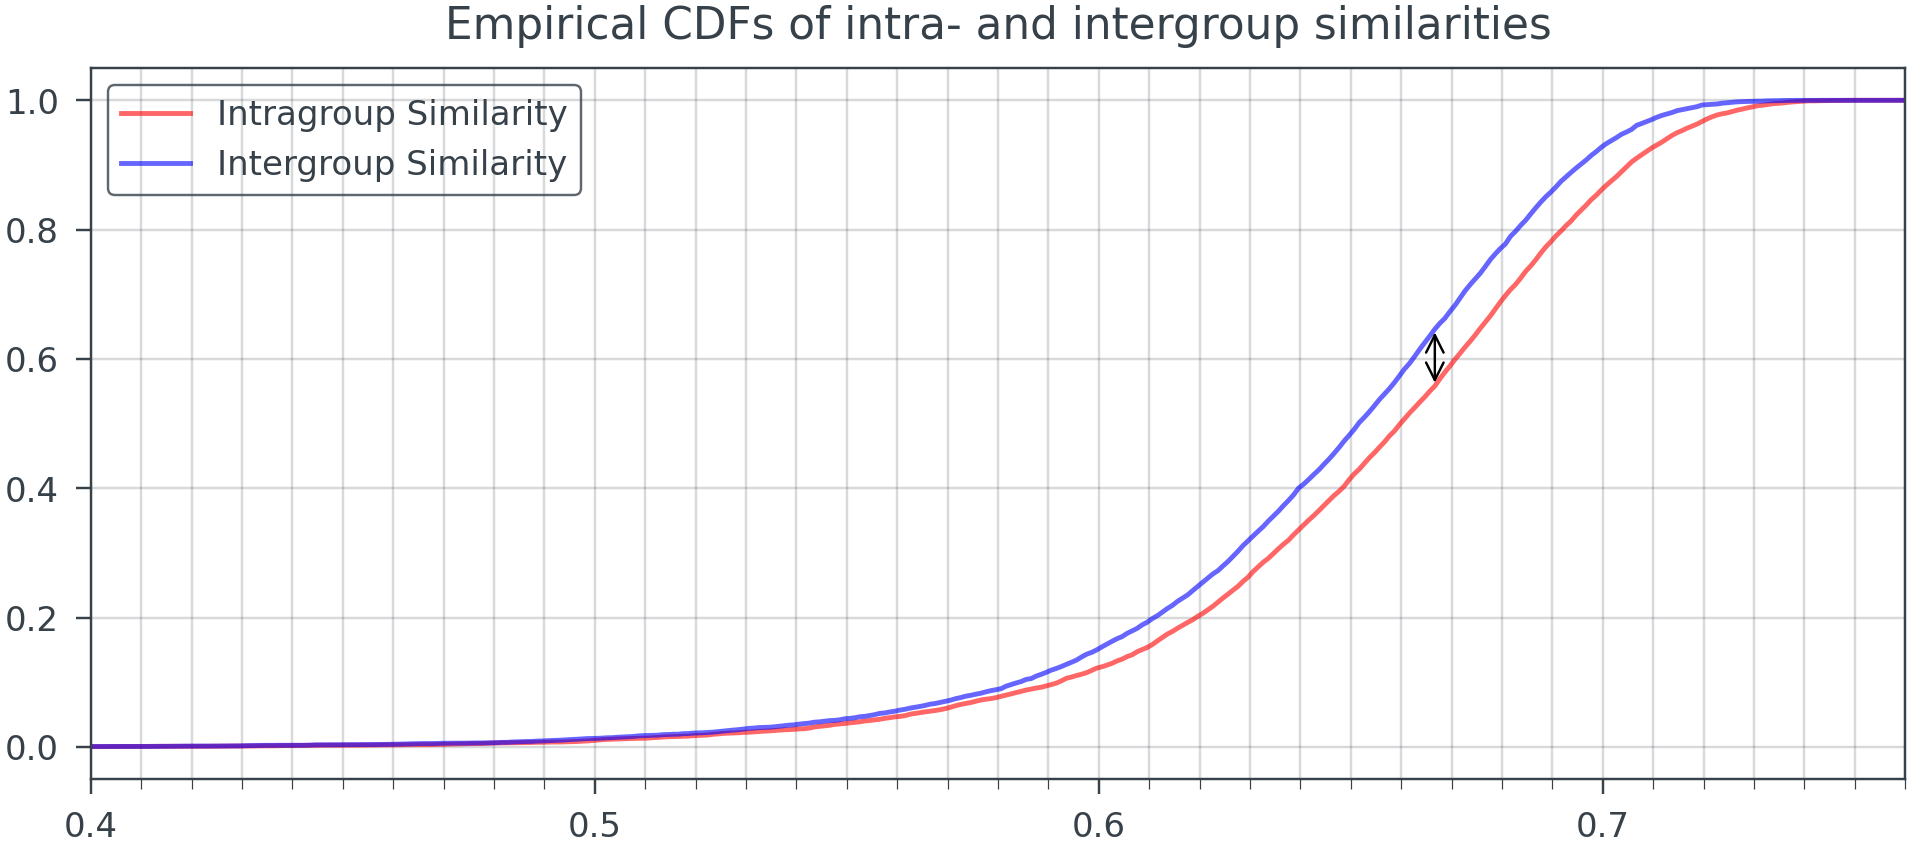

In [28]:
fig, ax  = plt.subplots()

plt.title("Empirical CDFs of intra- and intergroup similarities")

ax.xaxis.set_major_locator(plt.MultipleLocator(.1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(.01))

ax.plot(y, cdf_intra, color="red", alpha=.6, label="Intragroup Similarity")
ax.plot(y, cdf_inter, color="blue", alpha=.6, label="Intergroup Similarity")

ax.annotate("", xytext=(y[y_point], cdf_inter[y_point] + 0.01), xy=(y[y_point], cdf_intra[y_point] - 0.01),
            arrowprops=dict(arrowstyle="<->"))

ax.set_xlim(0.4, 0.76)
ax.grid(which="both")
ax.legend()

In [29]:
from scipy import stats
from tqdm import tqdm

# We are taking inter_sim and intra_sim coming from the same distribution as our null hypothesis and compute ks on every embedding model
p_values = []
for model in tqdm(MODELS):
    intra_sim, inter_sim = get_intra_inter_similarities(model, 'party')
    d, p_value = stats.ks_2samp(intra_sim, inter_sim)
    p_values.append(p_value)


 88%|████████▊ | 7/8 [01:00<00:08,  8.69s/it]


KeyboardInterrupt: 

In [ ]:
sum(p_values)

np.float64(4.487024550338499e-15)

sum of p values is very low meaning we have sufficient evidence to reject our null hypothesis and assume that party affiliation has some influence on speeches semantica values

## Compute for all embedding models

Next step is to derive some kind of cohesivness measure. We want to see how different intraparty similarities are from intra party similarities

In [ ]:
def get_cohesiveness(model: str, group_col: str) -> float:
    similarities = get_average_intra_inter_similarities(model=model, group_col=group_col)
    size = sum(sim['size'] for sim in similarities)
    cohesivness = sum((sim['intra'] / sim['inter'] - 1) * sim['size'] for sim in similarities) / size
    return cohesivness.item()

In [ ]:
for model in MODELS:
    print(model, get_cohesiveness(model, 'party'))

jinaai/jina-embeddings-v3 0.014354207552969456
jinaai/jina-embeddings-v4 0.014088530093431473
Snowflake/snowflake-arctic-embed-l-v2.0 0.024967778474092484
BAAI/bge-m3 0.01399853266775608
sentence-transformers/all-MiniLM-L6-v2 0.021690983325242996
sentence-transformers/all-mpnet-base-v2 0.016661599278450012
Qwen/Qwen3-Embedding-0.6B 0.019445743411779404
google/embeddinggemma-300m 0.027052881196141243


Based on this measure miniLM, snowflake and google embeddings are most promising. 

In [ ]:
intra_sim, inter_sim = get_intra_inter_similarities(model=MODELS[0], group_col="party")

In [90]:
from scipy.stats import gaussian_kde
from scipy.special import rel_entr

intra_kde = gaussian_kde(intra_sim)
inter_kde = gaussian_kde(inter_sim)

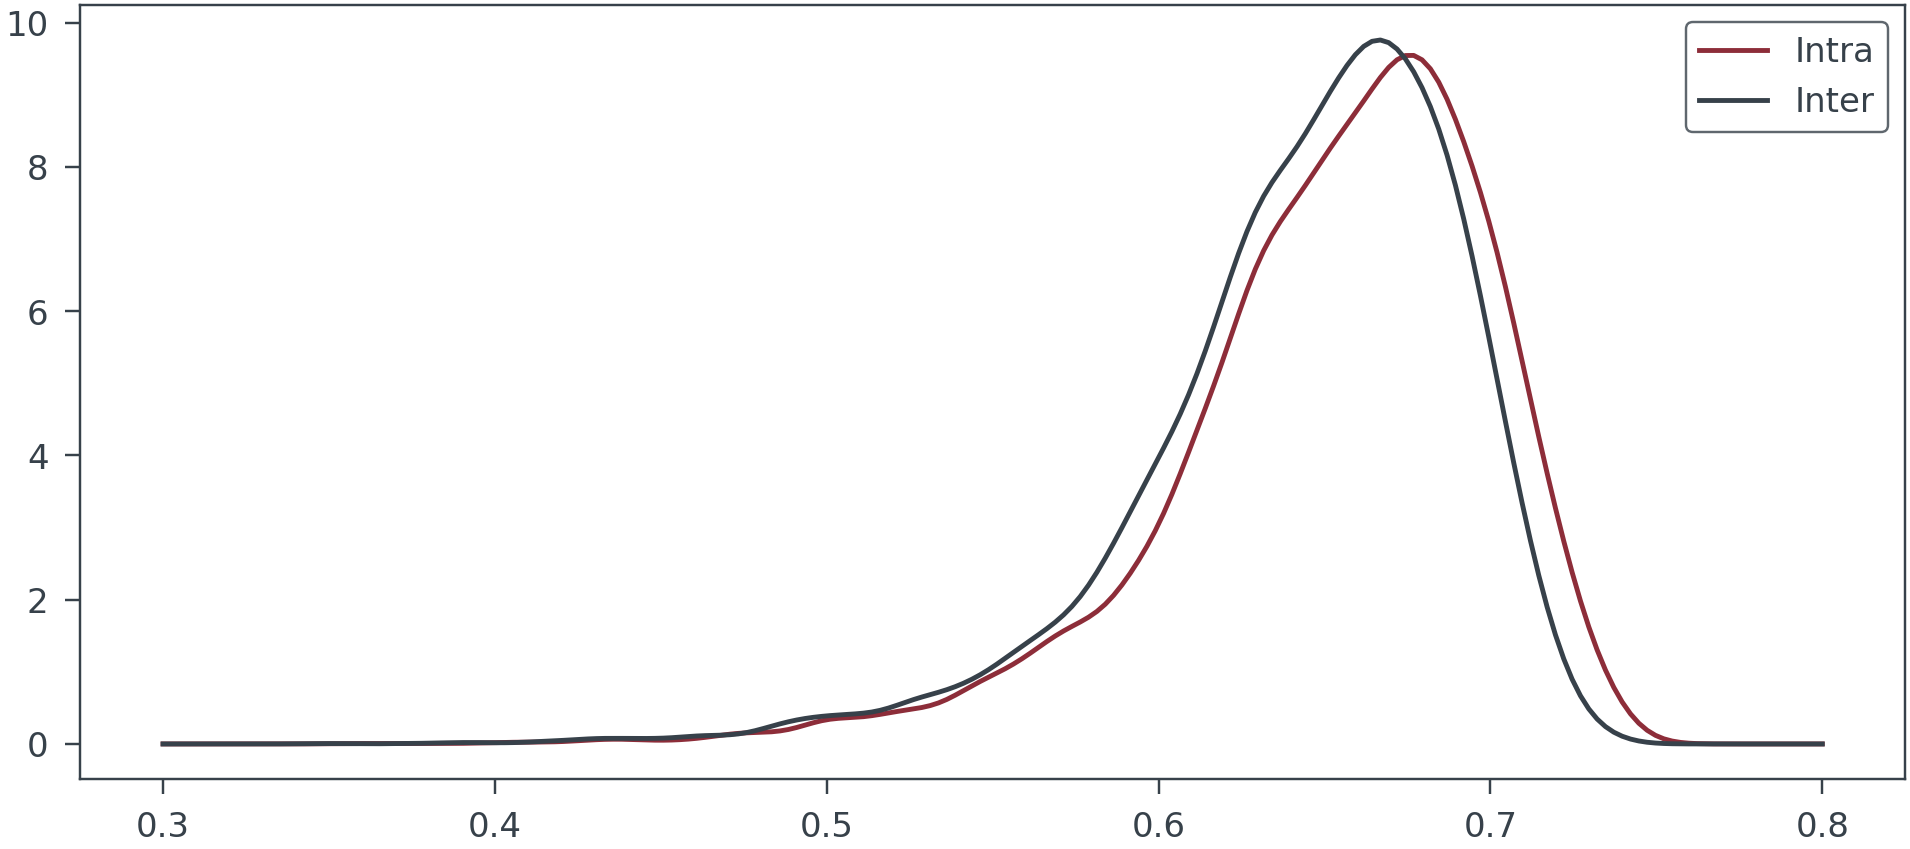

In [106]:
x = np.linspace(0.3, .8, 200)
plt.plot(x, intra_kde.pdf(x), label="Intra")
plt.plot(x, inter_kde.pdf(x), label="Inter")
plt.legend()

In [98]:
kl_div = ((intra_kde.logpdf(intra_sim) - inter_kde.logpdf(intra_sim)) * intra_kde.pdf(intra_sim)).mean()

In [99]:
assert np.isclose(rel_entr(intra_kde.pdf(intra_sim), inter_kde.pdf(intra_sim)).mean(), kl_div)

In [103]:
def get_cohesiveness_kl(model: str, group_col: str) -> float:
    intra_sim, inter_sim = get_intra_inter_similarities(model=model, group_col=group_col)
    intra_kde = gaussian_kde(intra_sim)
    inter_kde = gaussian_kde(inter_sim)
    kl_div = rel_entr(intra_kde.pdf(intra_sim), inter_kde.pdf(intra_sim))
    return kl_div.mean().item()

In [104]:
for model in MODELS:
    print(model, get_cohesiveness_kl(model, 'party'))

jinaai/jina-embeddings-v3 0.12178713977000952
jinaai/jina-embeddings-v4 0.18883655077554545
Snowflake/snowflake-arctic-embed-l-v2.0 0.05752979630855323
BAAI/bge-m3 0.10280633700525299
sentence-transformers/all-MiniLM-L6-v2 -0.0028824645109556584
sentence-transformers/all-mpnet-base-v2 -0.022829096050557312
Qwen/Qwen3-Embedding-0.6B 0.11387825440738068
google/embeddinggemma-300m 0.10410950285621307


# Other Influences

Based on earlier experiments we're assuming party affiliations have influence on speech embedding but we'd also like to know how strong is this influence and what're the other hidden variables that might have even stronger influence on the semantic representation of our speeches 

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer


In [ ]:

model = LogisticRegression(max_iter=1_000)
X = np.stack(df[MODELS[0]])
y = df['party']

print(f"#Classes {len(y.unique())}")

y = LabelEncoder().fit_transform(y)

cv = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(model, X, y, cv=cv, scoring="f1_macro")


#Classes 8


In [ ]:
scores.mean()

np.float64(0.3775611464061626)

In [ ]:
def compute_predictive_power(emb_model: str, target_var: str, continues: bool = False) -> np.array:
    print(f"Predicting {target_var}")

    model = LogisticRegression(max_iter=1_000)
    X = np.stack(df[emb_model])
    y = df[target_var]

    print(f"#Classes {len(y.unique())}")

    if continues:
        y = KBinsDiscretizer(encode="ordinal").fit_transform(np.stack(y)[:, np.newaxis]).reshape(-1)

    y = LabelEncoder().fit_transform(y)

    cv = StratifiedKFold(n_splits=10, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring="f1_macro")
    print(f"Mean Macro F1: {scores.mean()}")
    print(f"STD Macro F1: {scores.std()}")

    return scores

Try different target variables to see which has highest predictive power

In [ ]:
df.columns

Index(['Unnamed: 0', 'speaker', 'text', 'date', 'agenda', 'speechnumber',
       'procedure_ID', 'partyfacts_ID', 'period', 'chair', 'MEP', 'commission',
       'written', 'multispeaker', 'link', 'translatedText',
       'translationSource', 'year', 'block', 'party', 'migration_prob',
       'jinaai/jina-embeddings-v3', 'jinaai/jina-embeddings-v4',
       'Snowflake/snowflake-arctic-embed-l-v2.0', 'BAAI/bge-m3',
       'sentence-transformers/all-MiniLM-L6-v2',
       'sentence-transformers/all-mpnet-base-v2', 'Qwen/Qwen3-Embedding-0.6B',
       'google/embeddinggemma-300m', 'document', 'Clustering',
       'Classification', 'STS', 'Retrieval', 'Summarization'],
      dtype='object')

In [ ]:
TARGETS_PRED = ["party", "year", "block", "migration_prob"]

In [ ]:
compute_predictive_power(MODELS[0], "migration_prob", continues=True).mean()

Predicting migration_prob
#Classes 9702


/Users/nargizi/opt/anaconda3/envs/rl/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


Mean Macro F1: 0.41498515446330747
STD Macro F1: 0.015357363489507071


np.float64(0.41498515446330747)

In [ ]:
compute_predictive_power(MODELS[0], "party").mean()

Predicting party
#Classes 8
Mean Macro F1: 0.37646218317440194
STD Macro F1: 0.013879078990203837


np.float64(0.37646218317440194)

In [ ]:
compute_predictive_power(MODELS[0], "block").mean()

Predicting block
#Classes 6
Mean Macro F1: 0.40162189068456194
STD Macro F1: 0.023350221850869844


np.float64(0.40162189068456194)

logistical regression model has slightly higher predictive power of block variable

In [ ]:
compute_predictive_power(MODELS[0], "year").mean()

Predicting year
#Classes 11
Mean Macro F1: 0.4026618720564829
STD Macro F1: 0.02488366134817603


np.float64(0.4026618720564829)

In [ ]:
# probably not a good idea we have vert few examples per agenda item but at the same time I'd imagine that topic of the debate has highest influence on the semantical embeddings
# In order to measure that we'd need more data 
compute_predictive_power(MODELS[0], "agenda").mean()

Predicting agenda
#Classes 1054


/Users/nargizi/opt/anaconda3/envs/rl/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Mean Macro F1: 0.08716485616266045
STD Macro F1: 0.00672202744016171


np.float64(0.08716485616266045)

ultimaultimately we want to find how parties differ from each other meaning we would like to choose embedding model which captures party differences in the semantic model

In [ ]:
from tqdm import tqdm
results = []

for model in tqdm(MODELS):
    result = {"model": model}
    for target in TARGETS_PRED:
        scores = compute_predictive_power(model, target, continues=target == "migration_prob")
        result[target + "_mean"] = scores.mean() 
        result[target + "_std"] = scores.std()
    results.append(result)
    

  0%|          | 0/8 [00:00<?, ?it/s]

Predicting party
#Classes 8
Mean Macro F1: 0.3782972814980544
STD Macro F1: 0.01506020220987937
Predicting year
#Classes 11
Mean Macro F1: 0.4035786871477291
STD Macro F1: 0.023259885758487756
Predicting block
#Classes 6
Mean Macro F1: 0.39995722326274646
STD Macro F1: 0.016286823248555193
Predicting migration_prob
#Classes 9702


/Users/nargizi/opt/anaconda3/envs/rl/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
 12%|█▎        | 1/8 [01:06<07:43, 66.25s/it]

Mean Macro F1: 0.41401597333994644
STD Macro F1: 0.011043622311630329
Predicting party
#Classes 8
Mean Macro F1: 0.4312756464080126
STD Macro F1: 0.012902899131845839
Predicting year
#Classes 11
Mean Macro F1: 0.34141556191845296
STD Macro F1: 0.010986748227847756
Predicting block
#Classes 6
Mean Macro F1: 0.44308574257421895
STD Macro F1: 0.005216998393627378
Predicting migration_prob
#Classes 9702


/Users/nargizi/opt/anaconda3/envs/rl/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
 25%|██▌       | 2/8 [04:05<13:18, 133.01s/it]

Mean Macro F1: 0.4259797843732658
STD Macro F1: 0.012514329275441683
Predicting party
#Classes 8
Mean Macro F1: 0.4116647554911501
STD Macro F1: 0.022874864945721413
Predicting year
#Classes 11
Mean Macro F1: 0.44514440430607644
STD Macro F1: 0.019071205466678075
Predicting block
#Classes 6
Mean Macro F1: 0.43335427641655266
STD Macro F1: 0.01391520762775372
Predicting migration_prob
#Classes 9702


/Users/nargizi/opt/anaconda3/envs/rl/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
 38%|███▊      | 3/8 [05:13<08:34, 102.95s/it]

Mean Macro F1: 0.42372353807147717
STD Macro F1: 0.008413123181764619
Predicting party
#Classes 8
Mean Macro F1: 0.37706110542926824
STD Macro F1: 0.01600076167197478
Predicting year
#Classes 11
Mean Macro F1: 0.40433213379020305
STD Macro F1: 0.016348988481314296
Predicting block
#Classes 6
Mean Macro F1: 0.39687402920887144
STD Macro F1: 0.013895473570754414
Predicting migration_prob
#Classes 9702


/Users/nargizi/opt/anaconda3/envs/rl/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
 50%|█████     | 4/8 [06:23<05:59, 89.97s/it] 

Mean Macro F1: 0.415192012602529
STD Macro F1: 0.015858414626321832
Predicting party
#Classes 8
Mean Macro F1: 0.34746434008046184
STD Macro F1: 0.014007444961162066
Predicting year
#Classes 11
Mean Macro F1: 0.3709810603127514
STD Macro F1: 0.014877699130338855
Predicting block
#Classes 6
Mean Macro F1: 0.36687259207879347
STD Macro F1: 0.013025577671834834
Predicting migration_prob
#Classes 9702


/Users/nargizi/opt/anaconda3/envs/rl/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
 62%|██████▎   | 5/8 [06:46<03:17, 65.77s/it]

Mean Macro F1: 0.3884051024357348
STD Macro F1: 0.01212190717605316
Predicting party
#Classes 8
Mean Macro F1: 0.35703166532442865
STD Macro F1: 0.01444844424192743
Predicting year
#Classes 11
Mean Macro F1: 0.3819008192850585
STD Macro F1: 0.022099484032613238
Predicting block
#Classes 6
Mean Macro F1: 0.37199423380221774
STD Macro F1: 0.013111245406921641
Predicting migration_prob
#Classes 9702


/Users/nargizi/opt/anaconda3/envs/rl/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
 75%|███████▌  | 6/8 [07:53<02:12, 66.40s/it]

Mean Macro F1: 0.3918528122920334
STD Macro F1: 0.008874834504277266
Predicting party
#Classes 8
Mean Macro F1: 0.3944403402538048
STD Macro F1: 0.01642314998587278
Predicting year
#Classes 11
Mean Macro F1: 0.40963146808430695
STD Macro F1: 0.019633823897537993
Predicting block
#Classes 6
Mean Macro F1: 0.41674646799929577
STD Macro F1: 0.012735861390386008
Predicting migration_prob
#Classes 9702


/Users/nargizi/opt/anaconda3/envs/rl/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
 88%|████████▊ | 7/8 [09:01<01:06, 66.76s/it]

Mean Macro F1: 0.4184613017734808
STD Macro F1: 0.013496308439953232
Predicting party
#Classes 8
Mean Macro F1: 0.427682937026186
STD Macro F1: 0.01619228223054378
Predicting year
#Classes 11
Mean Macro F1: 0.4724784037288098
STD Macro F1: 0.02066191100283748
Predicting block
#Classes 6
Mean Macro F1: 0.43964553966474085
STD Macro F1: 0.011403626712980258
Predicting migration_prob
#Classes 9702


/Users/nargizi/opt/anaconda3/envs/rl/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
100%|██████████| 8/8 [09:35<00:00, 71.97s/it]

Mean Macro F1: 0.4224330280426883
STD Macro F1: 0.007229970533775017


In [ ]:
prediction_df = pd.DataFrame(results)
prediction_df

,model,party_mean,party_std,year_mean,year_std,block_mean,block_std,migration_prob_mean,migration_prob_std
0,jinaai/jina-embeddings-v3,0.378297,0.015060,0.403579,0.023260,0.399957,0.016287,0.414016,0.011044
1,jinaai/jina-embeddings-v4,0.431276,0.012903,0.341416,0.010987,0.443086,0.005217,0.425980,0.012514
2,Snowflake/snowflake-arctic-embed-l-v2.0,0.411665,0.022875,0.445144,0.019071,0.433354,0.013915,0.423724,0.008413
3,BAAI/bge-m3,0.377061,0.016001,0.404332,0.016349,0.396874,0.013895,0.415192,0.015858
4,sentence-transformers/all-MiniLM-L6-v2,0.347464,0.014007,0.370981,0.014878,0.366873,0.013026,0.388405,0.012122
5,sentence-transformers/all-mpnet-base-v2,0.357032,0.014448,0.381901,0.022099,0.371994,0.013111,0.391853,0.008875
6,Qwen/Qwen3-Embedding-0.6B,0.394440,0.016423,0.409631,0.019634,0.416746,0.012736,0.418461,0.013496
7,google/embeddinggemma-300m,0.427683,0.016192,0.472478,0.020662,0.439646,0.011404,0.422433,0.007230


In [ ]:
means = row.to_list()[1::2]
means

[np.float64(0.3782972814980544),
 np.float64(0.4035786871477291),
 np.float64(0.39995722326274646),
 np.float64(0.41401597333994644)]

In [ ]:
TARGETS_PRED

['party', 'year', 'block', 'migration_prob']

/var/folders/27/ks4jxwf13hn5277w8lg01sfw0000gn/T/ipykernel_74122/3043856419.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(TARGETS_PRED)


(0.0, 0.7)

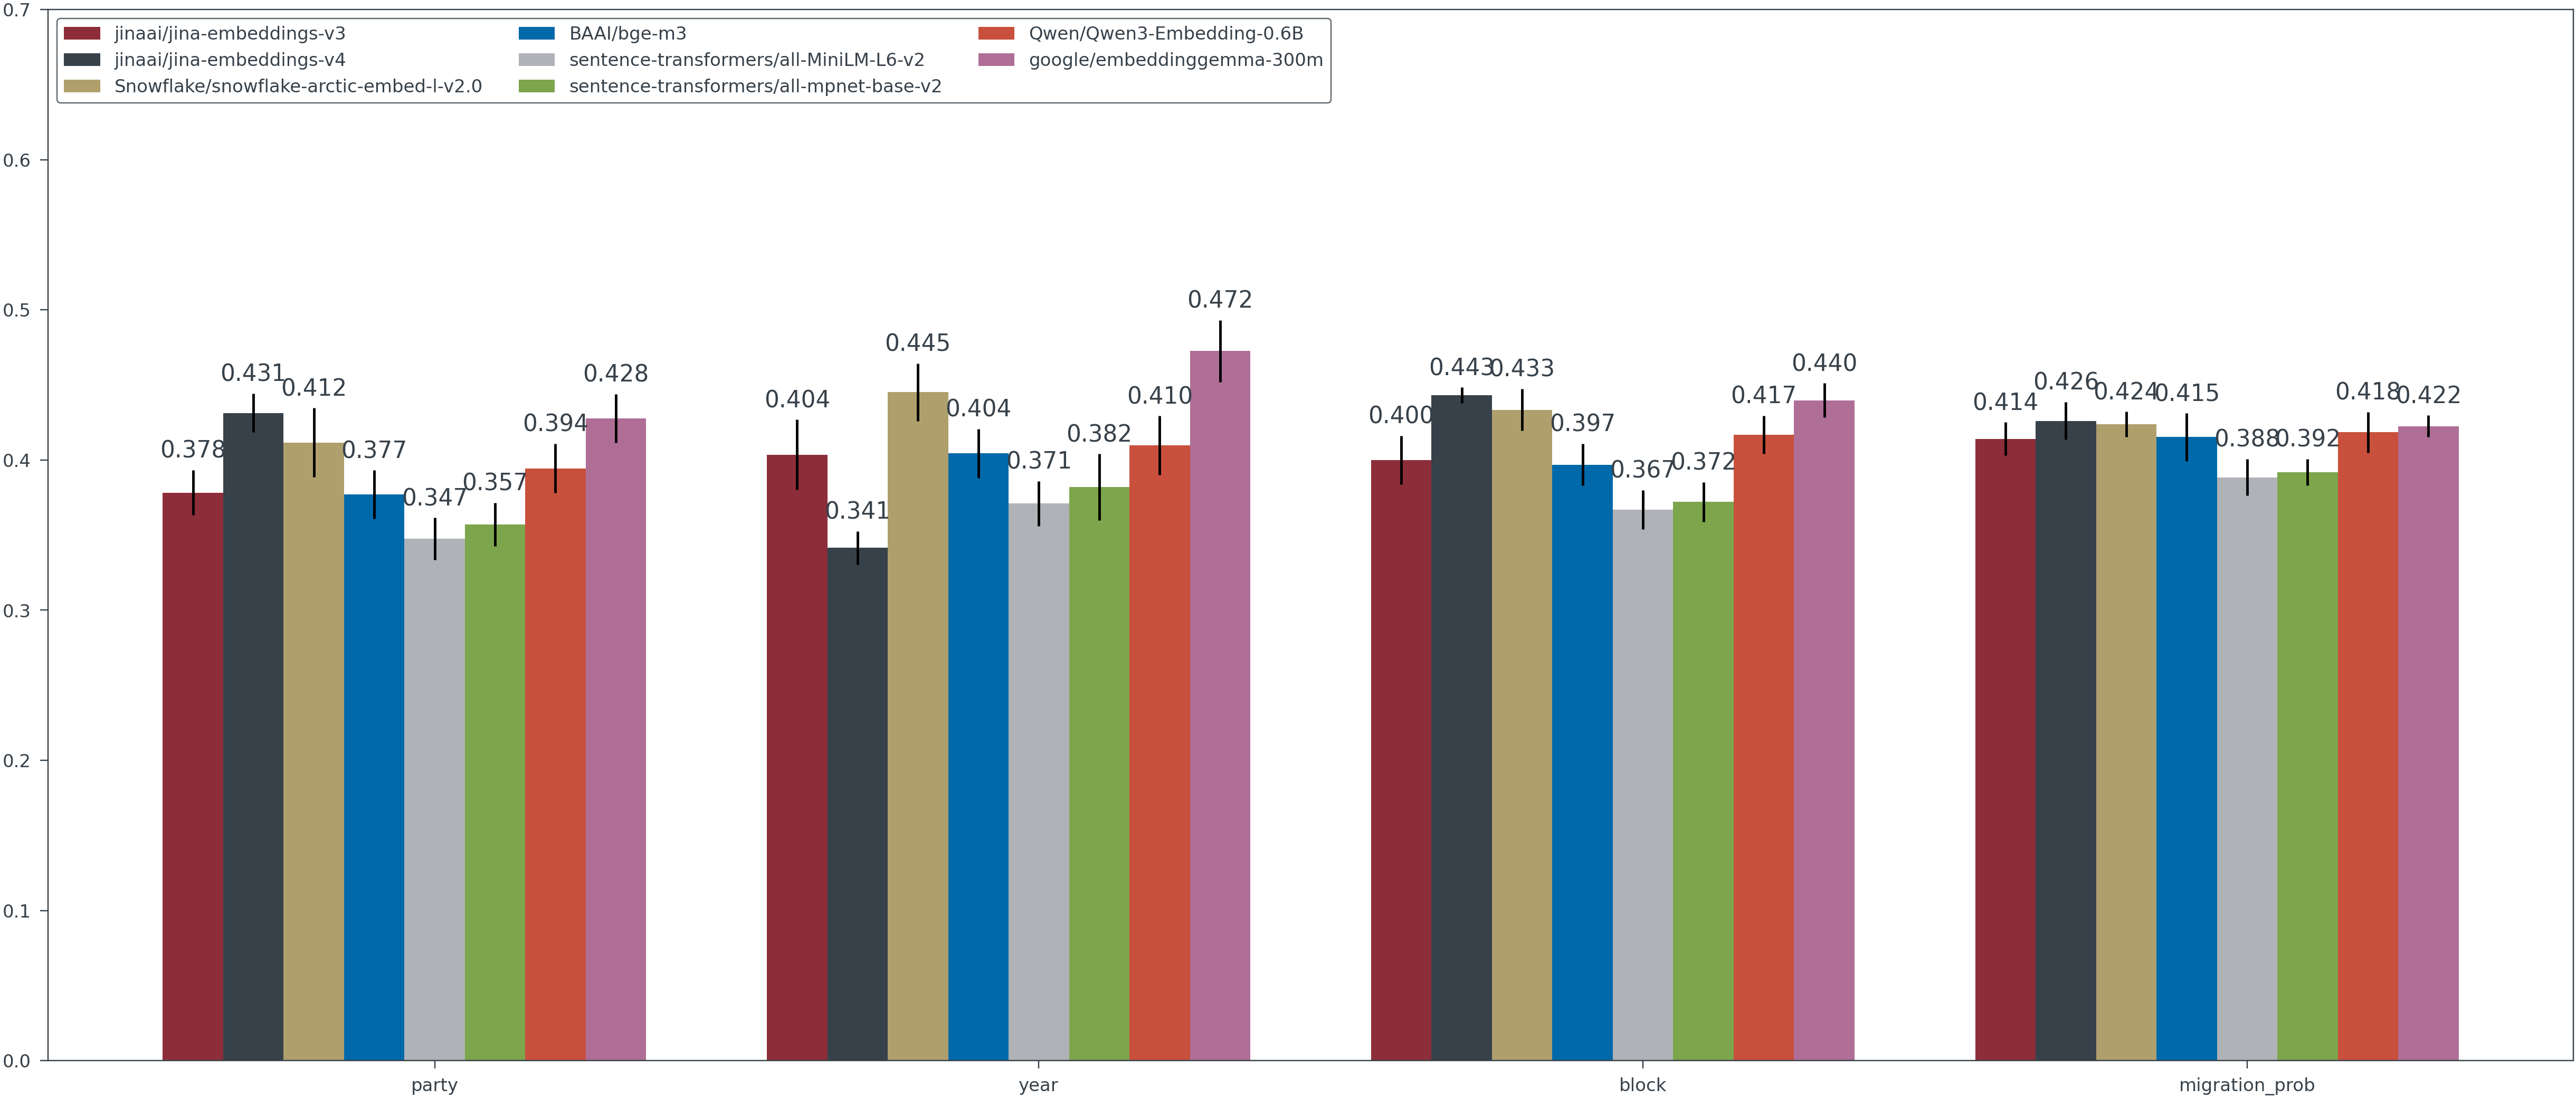

In [119]:
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(TARGETS_PRED))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

for row in prediction_df.iloc:
    means = row.to_list()[1::2]
    std = row.to_list()[2::2]
    offset = width * multiplier
    rects = ax.bar(x + offset, means, width, yerr=std, label=row['model'])
    ax.bar_label(rects, padding=3, fmt="{:.3f}")
    multiplier += 1

ax.legend(loc='upper left', ncols=3)

ax.set_xticklabels(TARGETS_PRED)
ax.xaxis.set_major_locator(plt.FixedLocator(x + 0.4))


ax.set_ylim(0, .7)


# ax.xaxis.set_major_locator(plt.MultipleLocator(1))
# ax.tick_params("x", rotation=45)

# for label in ax.get_xticklabels():
#     label.set_horizontalalignment('right')

# Clustering
We still don't know what influences our semantical embeddings the most and we'd like to see if unsupervised clustering would find clusters which captures party affiliations

In [40]:
from sklearn.manifold import TSNE

reduced = TSNE(n_components=2, metric="cosine").fit_transform(np.stack(df[MODELS[-1]]))

In [41]:
df['year'].unique()

array([2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014])

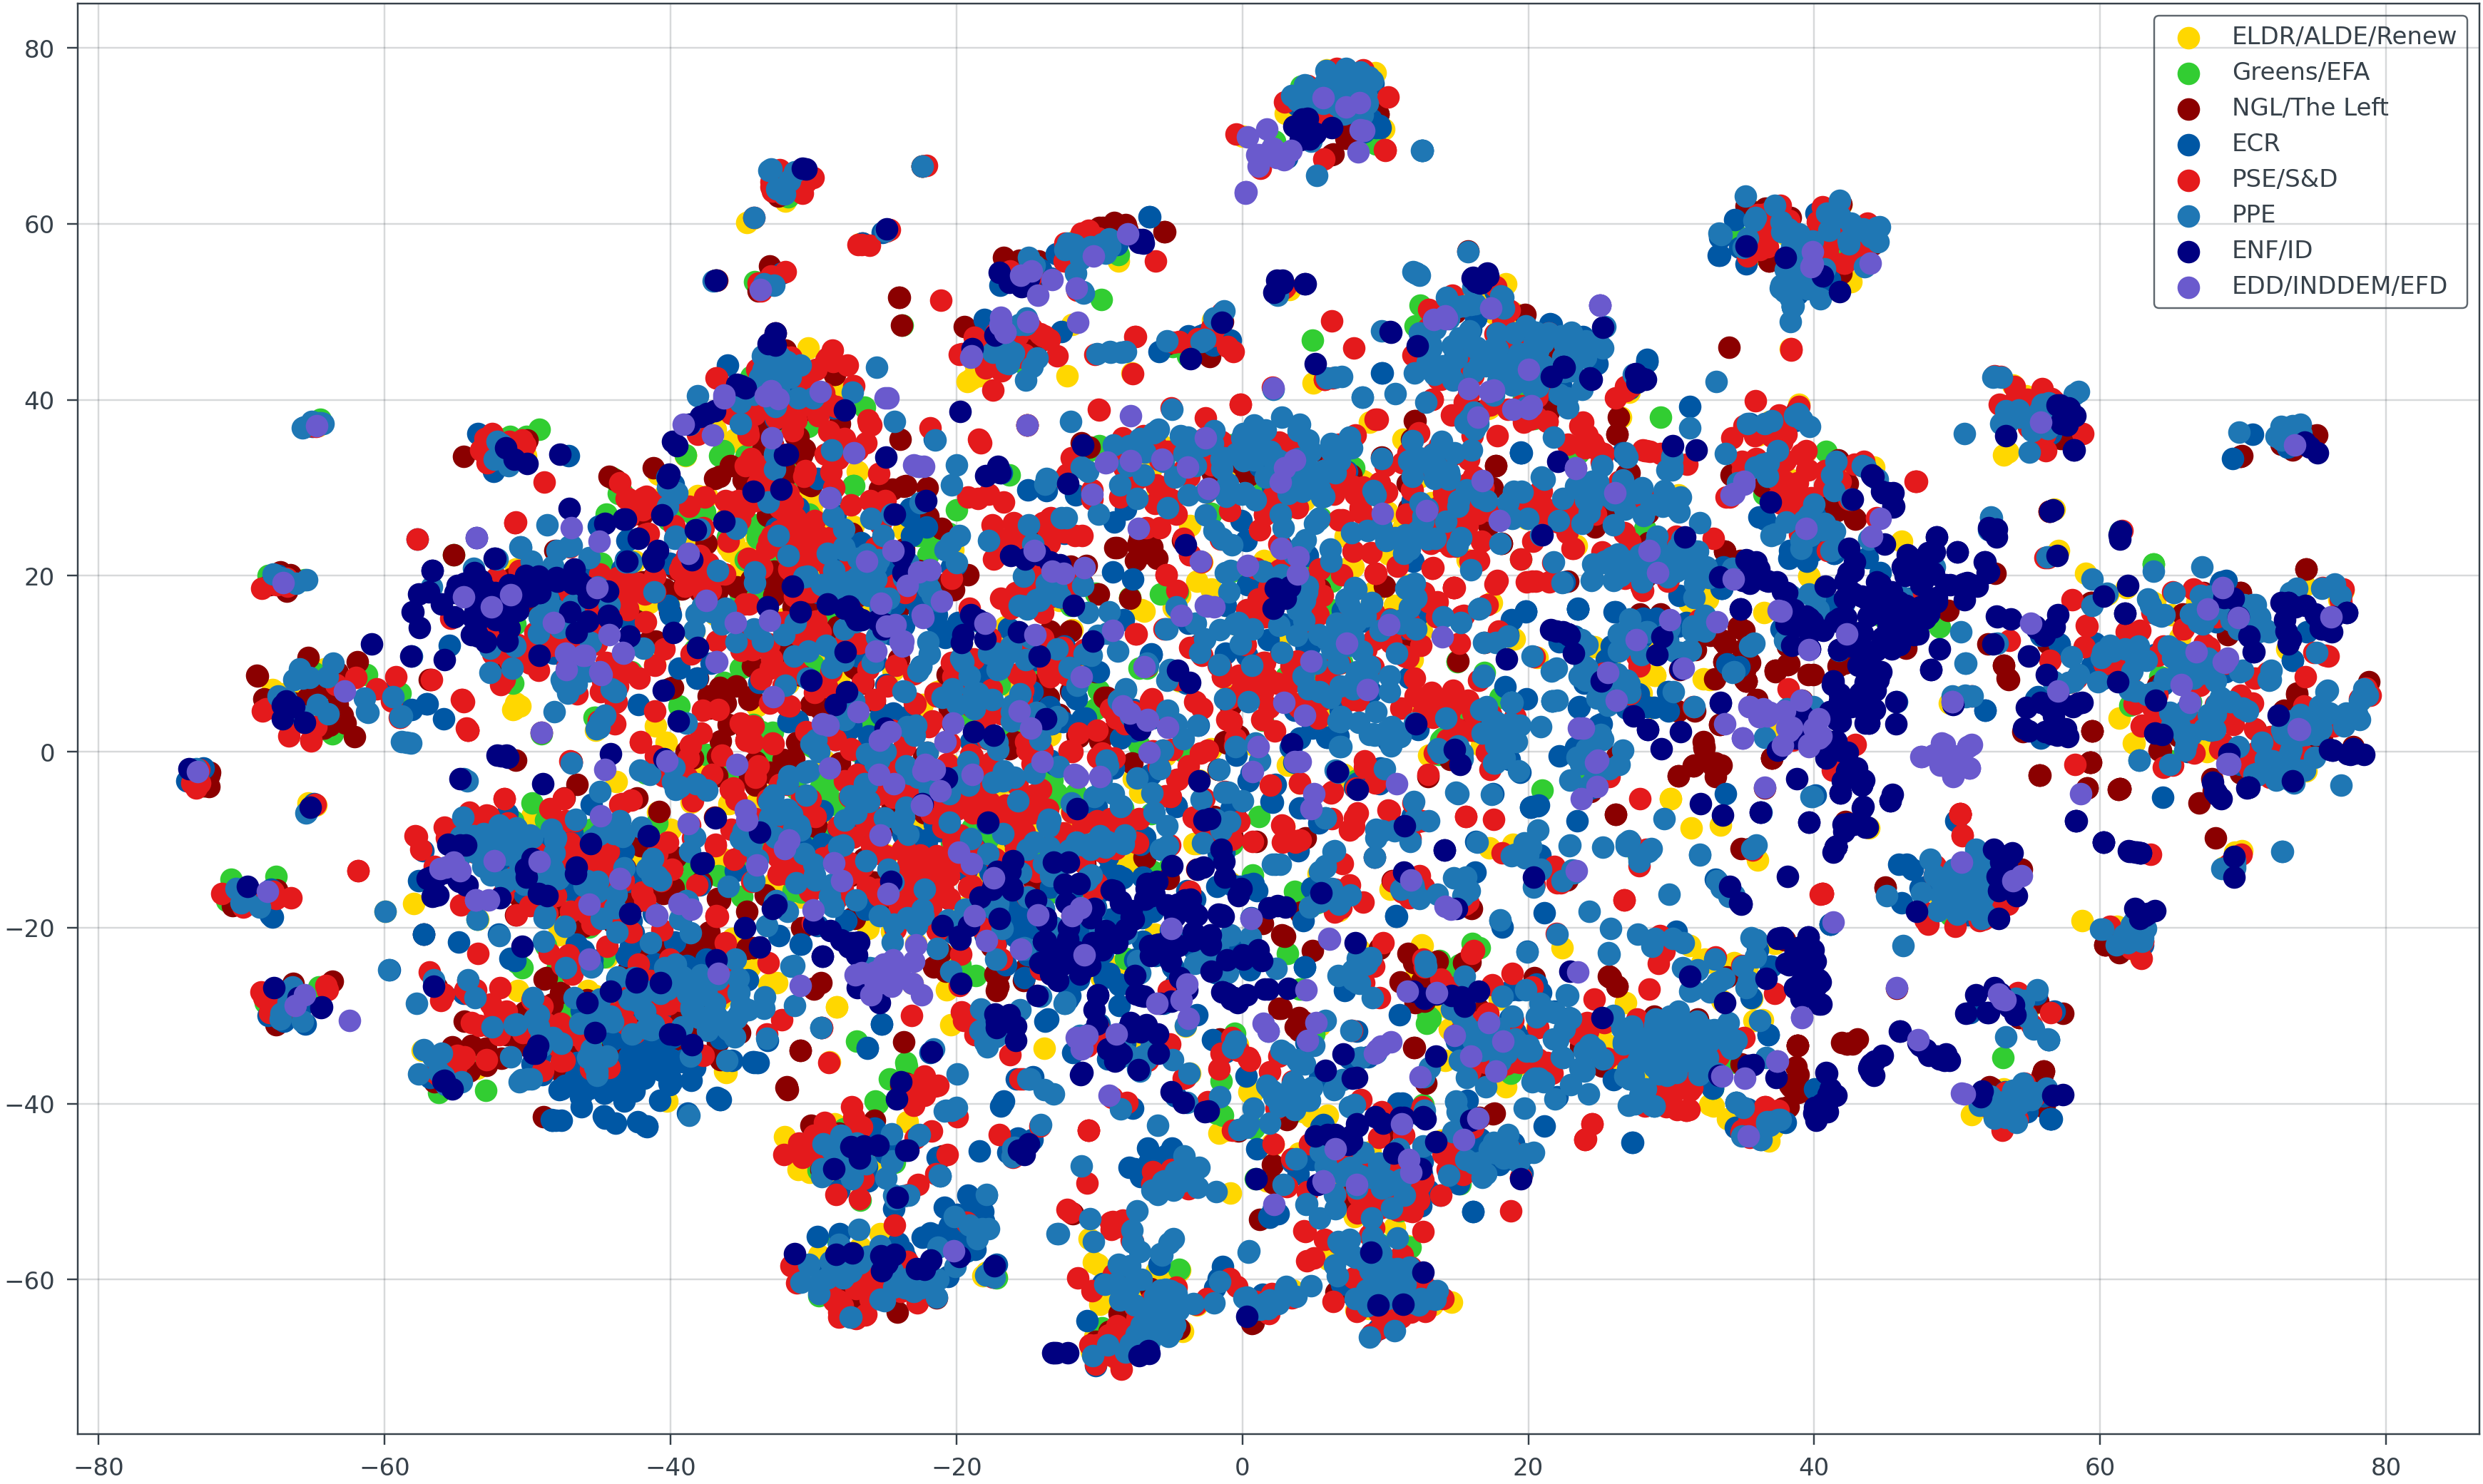

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))


for party in df['party'].unique():
    party_mask = df['party'] == party
    party_embeddings = reduced[party_mask]

    ax.scatter(party_embeddings[:, 0], party_embeddings[:, 1], c=COLOR_MAPS['party'][party], label=party)

ax.grid()
ax.legend()

In [120]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.cluster import KMeans

In [121]:
kmeans = KMeans(n_clusters=len(df['party'].unique()))
predicted_clusters = kmeans.fit_predict(np.stack(df[MODELS[0]]))

In [ ]:
# we want to measure if clusters we find are homogenious - speeches belonging to the same cluster come from the same party
# complete - speeches produced by a single party all belong to the same cluster
def evaluate_kmeans(true_labels, cluster_labels):
    h = homogeneity_score(true_labels, cluster_labels)
    c = completeness_score(true_labels, cluster_labels)
    v = v_measure_score(true_labels, cluster_labels)
    
    return {"homogeneity": h, "completeness": c, "v_measure": v}

In [123]:
evaluate_kmeans(df["party"], predicted_clusters)

{'homogeneity': 0.030278645928900345,
 'completeness': 0.028289722487316208,
 'v_measure': 0.029250413278821233}

Clusters found by kmeans aren't really defined by party affiliations.